In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 创建一个随机输入张量，模拟特征图
# 形状为 [1, 3, 6, 6]，表示1个样本，3个通道，6x6的特征图
input_tensor = torch.randn(1, 3, 6, 6)
print("输入张量的形状:", input_tensor.shape)

# 创建 AdaptiveAvgPool2d 层，指定输出大小为 2x2
adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

# 对输入张量进行自适应平均池化
output_tensor = adaptive_pool(input_tensor)
print("输出张量的形状:", output_tensor.shape)

输入张量的形状: torch.Size([1, 3, 6, 6])
输出张量的形状: torch.Size([1, 3, 2, 2])


In [9]:
import json
token = {"username":"eviltrashcan","key":"5a0836e4ef86086fdadf624206bd1421"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [10]:
!cat /content/kaggle.json

{"username": "eviltrashcan", "key": "5a0836e4ef86086fdadf624206bd1421"}

In [11]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [12]:
!kaggle competitions download -c cifar-10

 95% 680M/715M [00:03<00:00, 191MB/s]
100% 715M/715M [00:03<00:00, 219MB/s]


In [13]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [14]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [15]:
!ls competitions/cifar-10/train|wc -l

50000


In [17]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# colab加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"

# img_dir = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\train"
# labels_file = r"D:\BaiduNetdiskDownload\1.Python11期\深度学习代码\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [19]:
# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [20]:

# 定义VGG11模型
import torch.nn as nn

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()

        # 特征提取部分
        self.features = nn.Sequential(
            # 第一块: 输入通道3, 输出通道64, 3x3卷积, 然后是ReLU和最大池化
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第二块: 输入通道64, 输出通道128, 3x3卷积, 然后是ReLU和最大池化
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第三块: 两个连续的卷积层, 输入128, 输出256, 然后是ReLU和最大池化
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第四块: 两个连续的卷积层, 输入256, 输出512, 然后是ReLU和最大池化
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第五块: 两个连续的卷积层, 输入512, 输出512, 然后是ReLU和最大池化
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 分类器部分
        self.classifier = nn.Sequential(
            # 全连接层1: 将特征图展平后, 输入维度7*7*512, 输出4096
            nn.Linear(512, 4096),  # 对于32x32的CIFAR-10图像, 经过5次下采样后为1x1x512
            nn.ReLU(inplace=True),
            nn.Dropout(),  # 默认概率0.5，减少过拟合

            # 全连接层2: 输入4096, 输出4096
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            # 输出层: 输入4096, 输出类别数
            nn.Linear(4096, num_classes),
        )

        # 初始化权重
        self._initialize_weights()

    def forward(self, x):
        # 前向传播
        x = self.features(x)  # 特征提取
        x = x.view(x.size(0), -1)  # 展平特征图
        x = self.classifier(x)  # 分类
        return x

    def _initialize_weights(self):
        # 初始化模型权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 创建VGG11模型实例
model = VGG11(num_classes=10)
print(model)


VGG11(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [21]:
# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [22]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 28144010
模型总参数量: 28144010

各层参数量明细:
features.0.weight: 1728 参数
features.0.bias: 64 参数
features.3.weight: 73728 参数
features.3.bias: 128 参数
features.6.weight: 294912 参数
features.6.bias: 256 参数
features.8.weight: 589824 参数
features.8.bias: 256 参数
features.11.weight: 1179648 参数
features.11.bias: 512 参数
features.13.weight: 2359296 参数
features.13.bias: 512 参数
features.16.weight: 2359296 参数
features.16.bias: 512 参数
features.18.weight: 2359296 参数
features.18.bias: 512 参数
classifier.0.weight: 2097152 参数
classifier.0.bias: 4096 参数
classifier.3.weight: 16777216 参数
classifier.3.bias: 4096 参数
classifier.6.weight: 40960 参数
classifier.6.bias: 10 参数


In [23]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-0.0142,  0.0605, -0.0170],
                        [-0.0621, -0.0174,  0.0136],
                        [ 0.0369,  0.0119, -0.1252]],
              
                       [[ 0.0180,  0.0413,  0.0133],
                        [ 0.0114,  0.0735,  0.0059],
                        [-0.0310,  0.0234,  0.1123]],
              
                       [[ 0.0373,  0.0834,  0.0132],
                        [-0.0725,  0.0900, -0.0014],
                        [ 0.0567,  0.0272,  0.0410]]],
              
              
                      [[[ 0.0385,  0.1260,  0.0779],
                        [-0.0009,  0.0111, -0.0176],
                        [-0.0192,  0.1210, -0.0036]],
              
                       [[-0.0727,  0.0753, -0.0645],
                        [ 0.0294, -0.0658,  0.0243],
                        [-0.0336, -0.1148,  0.0703]],
              
                       [[ 0.0526,  0.0820, -0.0433],
                     

In [24]:
model = VGG11()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9
print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)


使用设备: cuda:0


Training Progress:   0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 74.4200
早停: 已有5轮验证损失没有改善！


In [26]:
history['train'][-100:-1]

[{'loss': 0.08705728501081467, 'acc': 98.4375, 'step': 18901},
 {'loss': 0.09738858044147491, 'acc': 95.3125, 'step': 18902},
 {'loss': 0.10475610941648483, 'acc': 96.875, 'step': 18903},
 {'loss': 0.10908207297325134, 'acc': 96.875, 'step': 18904},
 {'loss': 0.07636535912752151, 'acc': 96.875, 'step': 18905},
 {'loss': 0.12253587692975998, 'acc': 95.3125, 'step': 18906},
 {'loss': 0.009439780376851559, 'acc': 100.0, 'step': 18907},
 {'loss': 0.09993003308773041, 'acc': 95.3125, 'step': 18908},
 {'loss': 0.0263376422226429, 'acc': 98.4375, 'step': 18909},
 {'loss': 0.12221130728721619, 'acc': 96.875, 'step': 18910},
 {'loss': 0.24207952618598938, 'acc': 90.625, 'step': 18911},
 {'loss': 0.07333668321371078, 'acc': 96.875, 'step': 18912},
 {'loss': 0.13123351335525513, 'acc': 92.1875, 'step': 18913},
 {'loss': 0.043902523815631866, 'acc': 96.875, 'step': 18914},
 {'loss': 0.05196863412857056, 'acc': 96.875, 'step': 18915},
 {'loss': 0.12369143962860107, 'acc': 96.875, 'step': 18916},
 {

In [27]:
history['val'][-1000:-1]

[{'loss': 2.302637287521362, 'acc': 10.28, 'step': 0},
 {'loss': 2.2964109855651857, 'acc': 10.24, 'step': 500},
 {'loss': 2.2668755252838135, 'acc': 10.24, 'step': 1000},
 {'loss': 1.9673621101379395, 'acc': 25.26, 'step': 1500},
 {'loss': 1.7366922096252442, 'acc': 34.7, 'step': 2000},
 {'loss': 1.5817802448272704, 'acc': 40.58, 'step': 2500},
 {'loss': 1.5220348373413086, 'acc': 43.0, 'step': 3000},
 {'loss': 1.3660899229049683, 'acc': 49.58, 'step': 3500},
 {'loss': 1.340666604614258, 'acc': 51.18, 'step': 4000},
 {'loss': 1.1864029148101807, 'acc': 56.32, 'step': 4500},
 {'loss': 1.116842525291443, 'acc': 59.46, 'step': 5000},
 {'loss': 1.0648450333595276, 'acc': 61.52, 'step': 5500},
 {'loss': 1.055628265762329, 'acc': 61.62, 'step': 6000},
 {'loss': 1.0771126699447633, 'acc': 62.5, 'step': 6500},
 {'loss': 0.9684205775260926, 'acc': 64.86, 'step': 7000},
 {'loss': 0.9182575313568115, 'acc': 66.64, 'step': 7500},
 {'loss': 0.892205251789093, 'acc': 68.5, 'step': 8000},
 {'loss': 

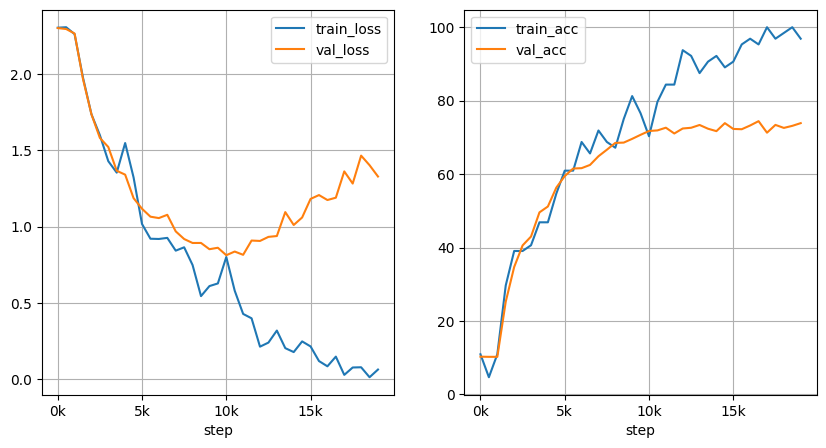

In [28]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps